# Handwritten letter recognizer

The purpose of this model is to develop a  Convolutional Neural Network for recognizing handwritten letters


### Import statements

In [155]:
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

import sys
sys.path.insert(1, "/home/azureuser/DataAnalyzer/src")

from data.data_validator import *
from data.data_processing import *

import string

from sklearn.metrics import confusion_matrix
import seaborn as sns

from matplotlib import pyplot


## The data preparation


### Data Validation

Validate the dataset using the data_validator method

Benchmark : le data_validator permet de vérifier chaque dossier
    Erreur identifié :
        UnidentifiedImageError /home/azureuser/letters_data/training/L/17625.jpg


In [156]:

training_path = "/home/azureuser/letters_dataset/training"
testing_path =  "/home/azureuser/letters_dataset/testing"
validation_path =  "/home/azureuser/letters_dataset/validation"


alphabet_string = string.ascii_uppercase
alphabet_list = list(alphabet_string)

for i in alphabet_list:
    data_validator(training_path + "/" + i)
    data_validator(testing_path  + "/" + i)
    data_validator(validation_path  + "/" + i)

### Generate directory to read images from & Data augmentation

#### Normalization

To avoid overfitting we will alter our dataset.
We chose :

    - Random rotation by 10° of some training image
    - Brightness_range from 30 to 70 : The user will take picture so we will adapt our model

    -Shift image to make them not in the center
        - Randomly shift images vertically
        - Randomly shift images horizontally


In [157]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.,rotation_range=10,width_shift_range=0.1,
        height_shift_range=0.1 # Randomly zoom image
) 
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.,rotation_range=10,  # Randomly zoom image
)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.,rotation_range=10, # Randomly zoom image
        width_shift_range=0.1,
        height_shift_range=0.1)

#### Generate and set directory to read images from with data augnemtation

In [158]:
#object of class ImageDataGenerator with the recale property
train_generator = train_datagen.flow_from_directory(training_path,batch_size=100,class_mode='sparse',target_size=(28, 28),color_mode="rgb",  shuffle=False)

test_generator = test_datagen.flow_from_directory(testing_path,class_mode='sparse',target_size=(28, 28),color_mode="rgb",  shuffle=False)

validation_generator = test_datagen.flow_from_directory(validation_path,class_mode='sparse',target_size=(28, 28),color_mode="rgb",  shuffle=False)


Found 182000 images belonging to 26 classes.
Found 52000 images belonging to 26 classes.
Found 26000 images belonging to 26 classes.


test_generator & train_generator are directory to read images from.
Each subdirectory (digits directory) in this directory will be considered to contain images from one class.

In [159]:
print(test_generator.image_shape)
print(train_generator.class_indices)

(28, 28, 3)
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


Invert directory:
This allow us to get the class name (get an A instead of a 0s)

In [160]:
dict_directory = {v: k for k, v in train_generator.class_indices.items()}
print(dict_directory)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


## Data Visualisation

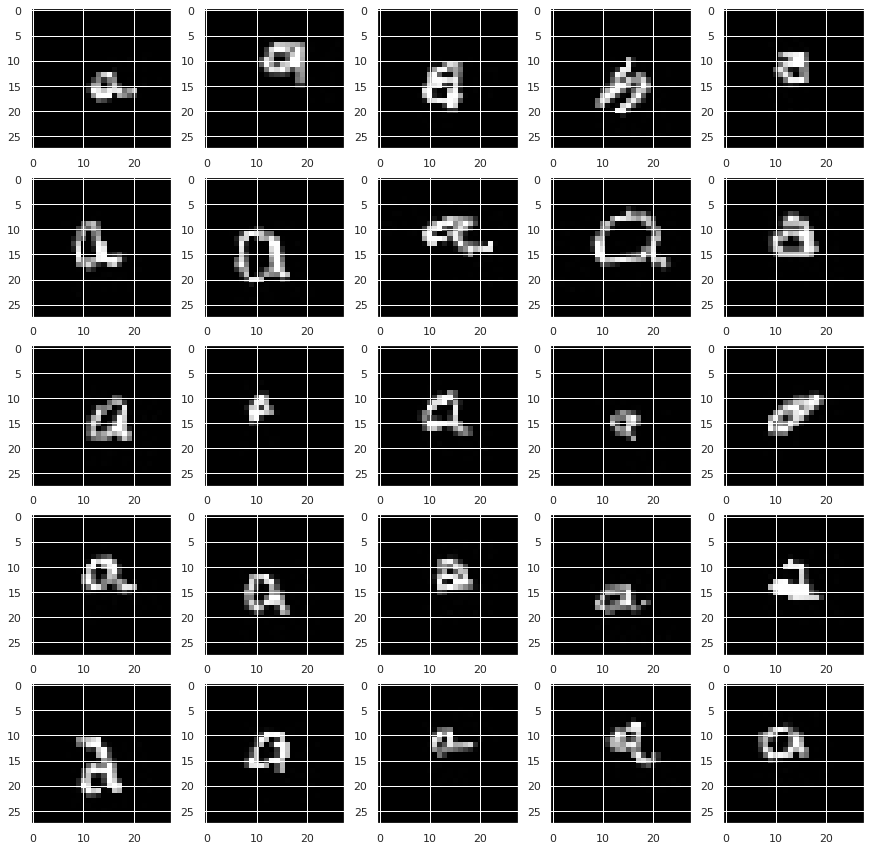

In [161]:
# plot first few images
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, i+1)
	# plot raw pixel data
	pyplot.imshow(train_generator[i][0][0], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()
sns.set(rc = {'figure.figsize':(15,15)})


## The CNN modeling and evaluation

### Model


Model : we have to avoid overfitting

Softmax :  Softmax takes a set of values, and effectively picks the biggest one, so, for example, if the output of the last layer looks like [0.1, 0.1, 0.05, 0.1, 9.5, 0.1, 0.05, 0.05, 0.05], it saves you from fishing through it looking for the biggest value, and turns it into [0,0,0,0,1,0,0,0,0] -- The goal is to save a lot of coding!
activation layer : tf.keras.layers.Dense(26, activation=tf.nn.softmax)])
26 : because we have ten classes

In [162]:

model_letters = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28,3)),
  tf.keras.layers.Conv2D(64, (2, 2), activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(26, activation='softmax')
])


## Summarize Model


    The layers and their order in the model.

    The output shape of each layer.

    The number of parameters (weights) in each layer.

    The total number of parameters (weights) in the model.


In [163]:
model_letters.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 64)        8256      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 9216)              0         
                                                                 
 dense_17 (Dense)            (None, 256)               2359552   
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                      

#### Visualize a Deep Learning Neural Network Model in Keras

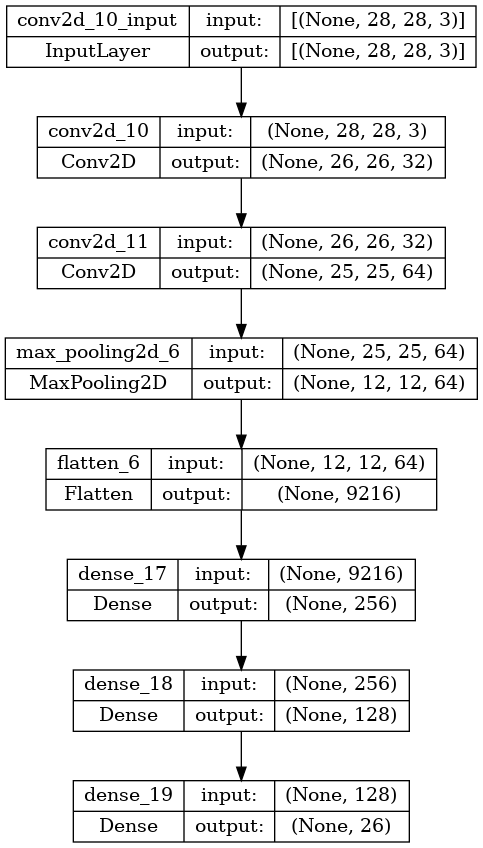

In [164]:
plot_model(model_letters, to_file='/home/azureuser/letters_dataset/benchmark/model_plot_letter_1.png', show_shapes=True, show_layer_names=True)

#### compile the model
Following the results got by  https://github.com/sanghvirajit/Feedforward_Neural_Network
We make the choice of the RMSprop optimizer


In [165]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model_letters.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#### Train the model

Reduce learning rate when a metric has stopped improving,we will gain in time while fitting the model by converging faster to the global minimum by decreasing the learning rate.
Set a learning rate annealer. we chose to decrease by 75%

In [166]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2, # number of epochs with no improvement after which learning rate will be reduced.
                                            verbose=1, #update messages
                                            factor=0.25, #new_lr = lr * factor`.
                                            min_lr=0.000001 # minimum learning rate
                                            )

## Fit the model

In [167]:
history = model_letters.fit(train_generator, epochs=10, 
        validation_data=validation_generator,  callbacks=[learning_rate_reduction])

Epoch 1/10
1820/1820 [==============================] - 281s 154ms/step - loss: 2.1641 - accuracy: 0.3620 - val_loss: 1.2759 - val_accuracy: 0.6237 - lr: 0.0010
Epoch 2/10
1820/1820 [==============================] - 279s 154ms/step - loss: 0.9233 - accuracy: 0.7178 - val_loss: 0.7676 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 3/10
1820/1820 [==============================] - 280s 154ms/step - loss: 0.6806 - accuracy: 0.7948 - val_loss: 0.7414 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 4/10
1820/1820 [==============================] - 280s 154ms/step - loss: 0.5678 - accuracy: 0.8300 - val_loss: 0.7180 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 5/10
1820/1820 [==============================] - 278s 153ms/step - loss: 0.5198 - accuracy: 0.8455 - val_loss: 0.5260 - val_accuracy: 0.8432 - lr: 0.0010
Epoch 6/10
1820/1820 [==============================] - 278s 153ms/step - loss: 0.4876 - accuracy: 0.8545 - val_loss: 0.5401 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 7/10
1820/1820 [============

## plot  curves

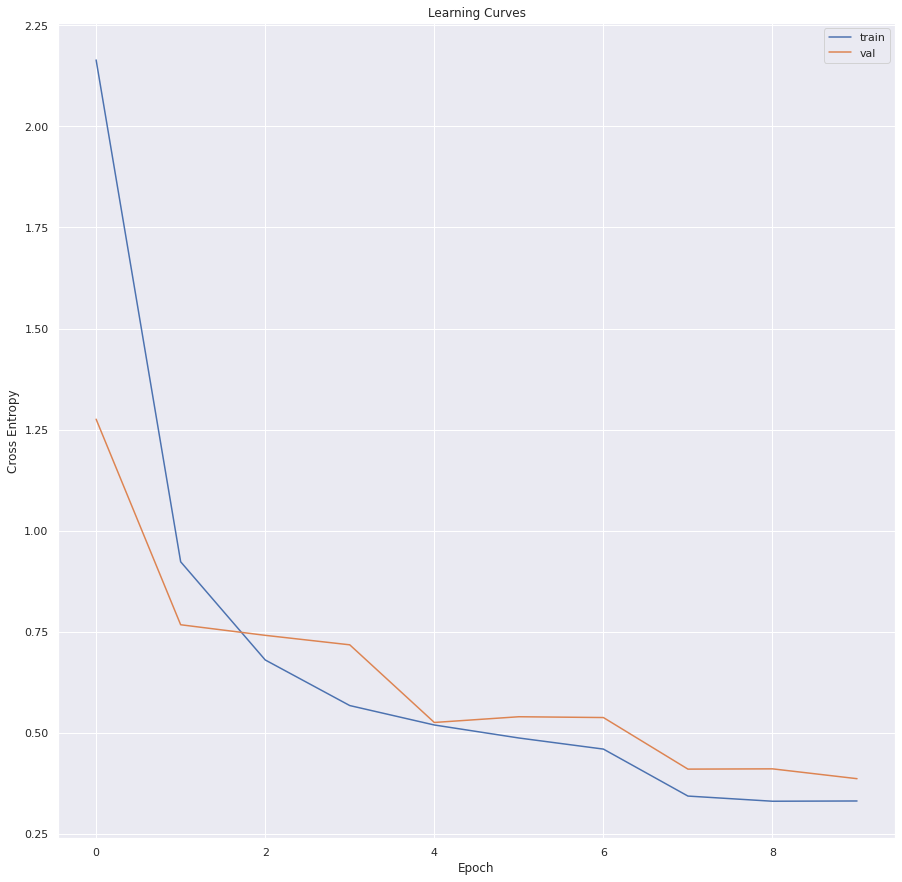

In [168]:
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

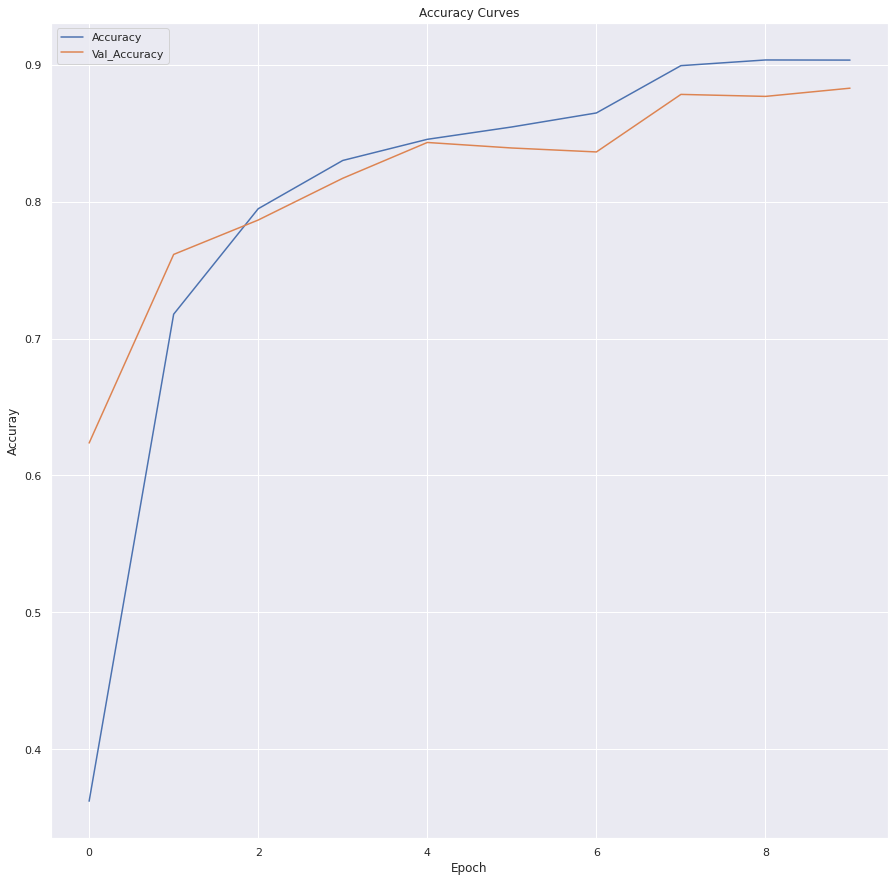

In [169]:
pyplot.title('Accuracy Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuray')
pyplot.plot(history.history['accuracy'], label='Accuracy')
pyplot.plot(history.history['val_accuracy'], label='Val_Accuracy')
pyplot.legend()
pyplot.show()

## Confusion matrix

In [180]:

test_generator.reset()
pred_list=[ ] # will store the predicted classes here
true_list=[]
classes=list(test_generator.class_indices.keys()) # ordered lst of class names 
prediction = model_letters.predict(test_generator)
predictions = prediction.argmax(axis=1)
labels=test_generator.labels
for i, p in enumerate (prediction):
    index=np.argmax(p)
    pred_list.append(classes[index])
    true_list.append(classes[labels[i]])
y_pred=np.array(pred_list)
y_true=np.array(true_list)



1625/1625 [==============================] - 38s 23ms/step


<AxesSubplot:>

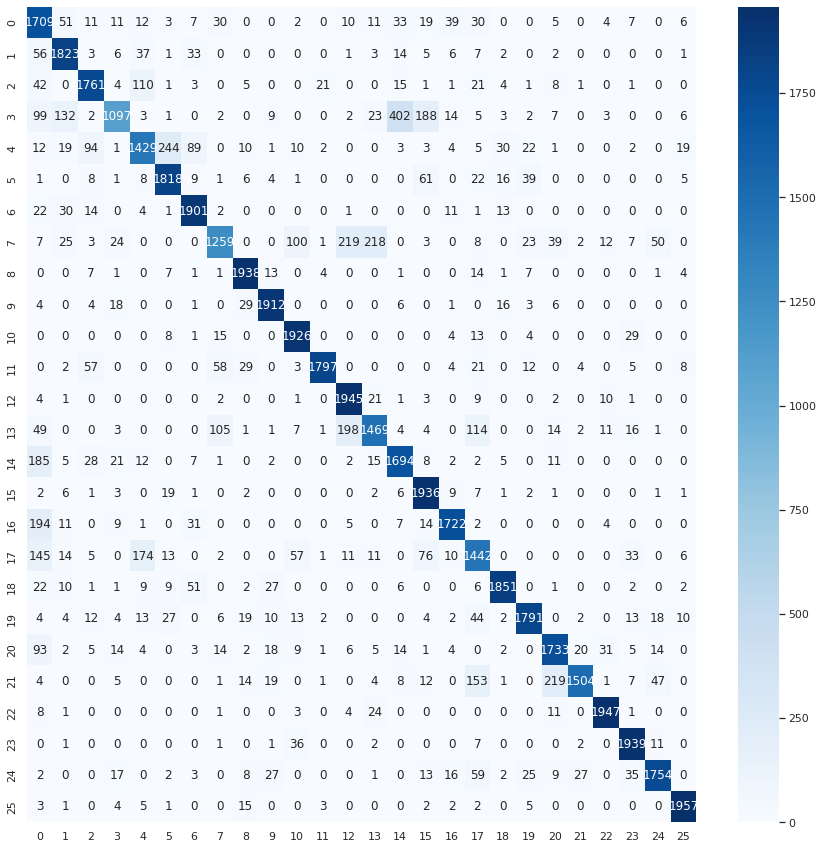

In [171]:
sns.set(rc = {'figure.figsize':(15,15)})
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm,annot=True, fmt='g', cmap='Blues')

## Model Evaluation

In [172]:


test_generator.reset()
# Evaluate on Validation data
scores = model_letters.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model_letters.metrics_names[1], scores[1]*100))


1625/1625 [==============================] - 39s 24ms/step - loss: 0.4565 - accuracy: 0.8650
evaluate accuracy: 86.50%


In [173]:
test_generator.reset()
pred=model_letters.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

1625/1625 [==============================] - 38s 23ms/step
[14  0  0 ... 25 25 25]


In [174]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
#voir les données qui reviennent souvent matrice de confusion
for i in alphabet_list:
    print(i + " " + str(predictions.count(i)))

A 2663
B 2132
C 2022
D 1225
E 1856
F 2186
G 2138
H 1484
I 2071
J 2035
K 2161
L 1825
M 2426
N 1810
O 2210
P 2375
Q 1842
R 1978
S 1959
T 1938
U 2053
V 1565
W 2024
X 2111
Y 1879
Z 2032


# Save letter model

In [175]:
model_letters.save("/home/azureuser/DataAnalyzer/src/models/letter4_model.h5")

In [176]:
index = predict_model("/home/azureuser/letters_dataset/testing/L/13270.jpg","letter",model_letters)
dict_directory[int(index)]

(28, 28, 3)
1/1 [==============================] - 0s 77ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[11]


'L'

In [177]:
index = predict_model("/home/azureuser/letters_dataset/validation/A/2220.jpg","letter",model_letters)
dict_directory[int(index)]

(28, 28, 3)
1/1 [==============================] - 0s 17ms/step
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
[0]


'A'

In [178]:
index = predict_model("/home/azureuser/letters_dataset/testing/X/0.jpg","letter",model_letters)
dict_directory[int(index)]

(28, 28, 3)
1/1 [==============================] - 0s 18ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0.]]
[23]


'X'